In [32]:
import numpy as np 
from subprocess import Popen, PIPE, STDOUT
import os
import matplotlib.pyplot as plt
import galsim

In [33]:
%pylab inline
from astropy.table import Table
import fitsio

Populating the interactive namespace from numpy and matplotlib


In [34]:
#directories that would be using 
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/'
repo = '/Users/Ismael/code/lensing/repo/'

In [35]:
os.chdir(WLD)
width = 512 
height = 512
psf_beta = 3.0 
psf_e1 = 0. #when it is 0 then the sigma matches the fwhm. 
psf_e2 = 0. 
psf_fwhm = 2.0 
airmass = 1.
pixel_scale = .2
truncate_radius = 30. 
min_snr = .05
cd = 1.06502 #disk. 
cb = 10.8396 #bulge 

In [41]:
#produces demo.fits file with partials, 
cmd = ('./simulate.py --catalog-name OneDegSq.fits --image-width {0} --image-height {1} \
--survey-name LSST --filter-band i --output-name demo --verbose --calculate_bias \
--mirror-diameter 0 --atmospheric-psf-beta {2} --atmospheric-psf-e1 {3} --atmospheric-psf-e2 {4} \
--zenith-psf-fwhm {5} --no-bulge --no-agn --airmass {6} --only-id 402700632300 --verbose-model').format(width,height,psf_beta,psf_e1,psf_e2,psf_fwhm,airmass)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print output


/Users/Ismael/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Read 858502 catalog entries from OneDegSq.fits
Simulating LSST i-band survey with {'exposure_time': 6900.0, 'sky_brightness': 20.0, 'mirror_diameter': 0.0, 'airmass': 1.0, 'zero_point': 41.5, 'survey_name': 'LSST', 'image_width': 512, 'filter_band': 'i', 'pixel_scale': 0.2, 'atmospheric_psf_beta': 3.0, 'cosmic_shear_g2': 0.0, 'zenith_psf_fwhm': 2.0, 'image_height': 512, 'effective_area': 33.212, 'extinction': 0.07, 'atmospheric_psf_e1': 0.0, 'cosmic_shear_g1': 0.0, 'atmospheric_psf_e2': 0.0} (obs.frac. = 0.000)
Will render all pixels with at least 33.8 detected electrons.
PSF dilution factor is 0.006585.
Simulation output will be saved to demo.fits
a_d,b_d: 1.12353277206,0.299915492535
Building galaxy model for id=40270

In [37]:
catalog = Table.read('demo.fits', hdu=1)
fits = fitsio.FITS('demo.fits')

In [38]:
#example particular columns and conditions out of the fits file. 
print catalog.colnames
selected = ((catalog['grp_size'] == 1) & (catalog['snr_grpf']>20) & (catalog['visible'] == 1))
selected_catalog = catalog[selected]
selected_catalog

['db_id', 'grp_id', 'grp_size', 'grp_rank', 'visible', 'xmin', 'xmax', 'ymin', 'ymax', 'f_disk', 'f_bulge', 'dx', 'dy', 'z', 'ab_mag', 'ri_color', 'flux', 'sigma_m', 'sigma_p', 'e1', 'e2', 'a', 'b', 'beta', 'psf_sigm', 'purity', 'snr_sky', 'snr_iso', 'snr_grp', 'snr_isof', 'snr_grpf', 'ds', 'dg1', 'dg2', 'ds_grp', 'dg1_grp', 'dg2_grp', 'hsm_sigm', 'hsm_e1', 'hsm_e2', 'g1_fit', 'g2_fit']


db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700632300,402700632300,1,0,1,155,197,341,395,1.0,0.0,-15.9555,22.4338,1.38524,22.5413,0.43375,1.04996e+06,0.734498,1.04044,-0.559721,0.146625,1.42162,0.379487,1.44269,1.68332,1.0,64.3599,64.1699,64.1699,44.2577,44.2577,0.133852,0.128031,0.0522609,0.133852,0.128031,0.0522609,nan,nan,nan,0.0,0.0


In [17]:
import math 
os.chdir(repo)
import galfun
import fisher

SyntaxError: invalid syntax (galfun.py, line 295)

In [25]:
for row in selected_catalog:
    galaxy_id = row['db_id']
    os.chdir(WLD)
    cmd = './fisher.py --i demo.fits -o notebooks/example.png --galaxy {0} --label-color white --no-display --bias --covariance'.format(galaxy_id)
    status,output = commands.getstatusoutput(cmd)
    print 'galaxy {0}:'.format(galaxy_id) 
    print 'WLD:'
    print output
    print
    os.chdir(repo)
#     g = (row['a'] - row['b'])/ (row['a'] + row['b'])
#     theta = math.atan2(row['e2'],row['e1'])
#     g1 = g*math.cos(theta)
#     g2 = g*math.sin(theta)
    e = math.sqrt(row['e1']**2 + row['e2']**2)
    hlr = row['sigma_m']*math.sqrt(1 - e**2)/math.sqrt(cd) #look at appendix of David's paper. 
    project_name = 'project'
    snr = row['snr_sky']
    cmd = ('python generate.py -p {0} -gal 1 --psf_model psf_moffat --galaxy-model exponential --g1 {1} --g2 {2} --y0 0 --x0 0 '
            '--flux {3} --psf_flux 1. --hlr {4} --psf_fwhm {5} --snr {6} --psf_beta {7}').format(project_name,row['e1'],row['e2'],row['flux'],hlr,psf_fwhm,snr,psf_beta)
    output = commands.getoutput(cmd)
    g_parameters = galfun.GParameters(project_name)
    print 
    fish = fisher.Fisher(g_parameters=g_parameters, snr=float(snr))
    print 'repo:'
    for param in fish.biases:
        std = math.sqrt(fish.covariance_matrix[param,param])
        bias = fish.biases[param]
        print param
        print 'value: {0}'.format(g_parameters.params[param])
        print 'std: {0}'.format(std)
        print 'bias: {0}'.format(bias)
        print 'bias/std: {0}'.format(bias/std)
    print


galaxy 402700632300:
WLD:
flux
std: 14282.1765081
bias: 179.348438284
bias/std: 0.0125575004749
x
std: 0.00576126793245
bias: 7.66723022045e-10
bias/std: 1.33082340734e-07
y
std: 0.0116551954687
bias: -5.11655840805e-09
bias/std: -4.38993787945e-07
s
std: 0.0232631065887
bias: -0.000471679253146
bias/std: -0.0202758497171
g1
std: 0.0205154428122
bias: -0.000624405725571
bias/std: -0.0304358882861
g2
std: 0.0104945368142
bias: 0.000163657972176
bias/std: 0.0155945874577


repo:
hlr_1
value: 0.580486758006
std: 0.0134365250221
bias: -0.000272697710898
bias/std: -0.0202952556891
g2_1
value: 0.146624594927
std: 0.0124967177322
bias: 4.81439055875e-05
bias/std: 0.00385252404824
g1_1
value: -0.559720814228
std: 0.0138508995951
bias: -0.000183690222912
bias/std: -0.0132619705782
x0_1
value: 0.0
std: 0.00568503188762
bias: -6.22094376013e-09
bias/std: -1.0942671709e-06
flux_1
value: 1049961.125
std: 14235.0424305
bias: 175.899932861
bias/std: 0.0123568253288
y0_1
value: 0.0
std: 0.011546563032

## Example demonstrating David's code on moments

In [26]:
import math 
from descwl.model import moments_size_and_shape
from descwl.model import sersic_second_moments
#got entry from exponential galaxy in the table 
n = 1 #sersic index 
e1 = -0.559721
e2 = 0.146625
a = 0.945682
b = 0.25244
hlr = math.sqrt(a*b) #should be sigma_m, 0.488598
q = b/a
beta = .5*math.atan2(e2,e1) #should be beta in table, 1.44269
emag1 = math.sqrt(e1**2 + e2**2)
emag2 = (1. - q)/(1. + q)
assert round(emag1,3) == round(emag2,3), "input a,b not consistent with e1,e2"
print "input values are (in order): hlr, q, beta, e1,e2,a,b:\n",hlr,q,beta,e1,e2,a,b
print
Q = sersic_second_moments(n,hlr,q,beta)
sigma_m,sigma_p,a1,b1,beta1,e11,e21 = moments_size_and_shape(Q)
hlr1 = math.sqrt(a1*b1)
q1 = b1/a1
print "output values are (in order): hlr, q, beta,e1,e2,a, b:\n",hlr1,q1,beta1,e11,e21,a1,b1

ImportError: No module named descwl.model

### Manual checking by entries by forcing what I think are the correct values (look at table above) 

In [57]:
import math 
os.chdir(repo)
import galfun
import fisher

In [58]:
# a = 0.945682
# b = 0.25244
#all gotten from the table except a_d, b_d, disk_hlr_arcsecs
galaxy_id = 402700632300
e1 = -0.559721 #in David's this is g1,g2 of Galsim. 
e2 = 0.146625
x0 = -0.055495199978
y0 =-0.066240169092
mean_sky_level =455991.953152
disk_hlr_arcsecs = 0.58048676532 #sqrt(a_d*b_d) 
flux = 1049961.07539
snr = 117.066 ## snr_sky
project_name = 'project11'
os.chdir(WLD)
cmd = './fisher.py --i demo.fits -o notebooks/example.png --galaxy {0} --label-color white --no-display --bias --covariance'.format(galaxy_id)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print 'galaxy {0}:'.format(galaxy_id) 
print 'WLD:'
print output
print
os.chdir(repo)
cmd = ('python generate.py -p {0} -gal 1 --psf_model psf_moffat --galaxy-model exponential --g1 {1} --g2 {2} --y0 {3} --x0 {4} '
        '--flux {5} --psf_flux 1. --hlr {6} --psf_fwhm {7} --snr {8} --psf_beta {9}').format(
        project_name,e1,e2,y0,x0,flux,disk_hlr_arcsecs,psf_fwhm,snr,psf_beta)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
g_parameters = galfun.GParameters(project_name)
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale, mean_sky_level=mean_sky_level, min_snr=min_snr, truncate_radius=truncate_radius)
fish = fisher.Fisher(g_parameters=g_parameters, snr=float(snr))
print 'repo:'
for param in fish.biases:
    std = math.sqrt(fish.covariance_matrix[param,param])
    bias = fish.biases[param]
    print param
    print 'value: {0}'.format(g_parameters.params[param])
    print 'std: {0}'.format(std)
    print 'bias: {0}'.format(bias)
    print 'bias/std: {0}'.format(bias/std)
print

galaxy 402700632300:
WLD:
/Users/Ismael/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
flux
std: 23732.7670701
bias: 740.159973365
bias/std: 0.0311872598412
x
std: 0.0229853243957
bias: -1.44443194885e-08
bias/std: -6.28414863322e-07
y
std: 0.0317307933778
bias: 3.46084637792e-08
bias/std: 1.0906901497e-06
s
std: 0.133892808031
bias: -0.0251973256756
bias/std: -0.188190284797
g1
std: 0.128052123399
bias: -0.0313457614711
bias/std: -0.244789079939
g2
std: 0.0522907018638
bias: 0.0082101963145
bias/std: 0.157010635196



repo:
hlr_1
value: 0.58048676532
std: 0.0441311605458
bias: -0.00451854430139
bias/std: -0.102388975171
g2_1
value: 0.146625
std: 0.0321069144633
bias: 0.00106363731902
bias/std: 0.0331279830778
g1_1
value: -0.559721
std: 0.0488435167575
bias: -0.00406579114497
bia

In [174]:
# # I am now going to do a pixel by pixel comparison to figure out differences. 
# entry = 0 
# #find corresponding entry 
# for i,elem in enumerate(fits[1]):
#     if elem[0] == 402700632300: 
#         entry = i
#         for j,e in enumerate(elem): 
#             print catalog.colnames[j]+ ': ' + str(e)
# print
# print entry 


0.0
4276.11474609
1018380.93363
(55, 43)


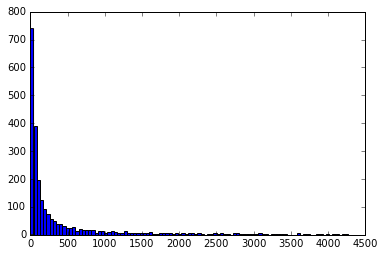

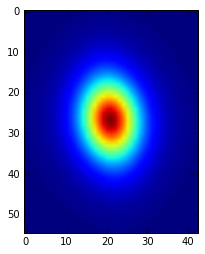

In [18]:
#compare histograms of both images, this is the one in the datacube 
img_wld = fits[2].read()[0]
plt.figure()
print img_wld.min() 
print img_wld.max()
print sum(img_wld)
print img_wld.shape
_ = plt.hist(img_wld.flatten(),np.linspace(img_wld.min(),img_wld.max(),num=100))
plt.figure()
plt.imshow(img_wld)

(galsim.Convolve(galsim.Exponential(scale_radius=0.345868148108, flux=1049961.07539).shear(galsim.Shear(g1=-0.559721,g2=0.146625)).shift(-0.055495199978,-0.066240169092), galsim.Moffat(beta=3.0, scale_radius=0.686510711845)))
0.624917
14529.5
(49, 23)
1.04429e+06


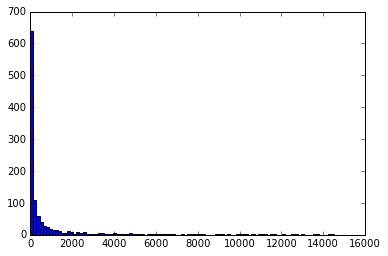

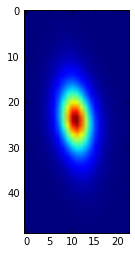

In [43]:
f = fish.image.array
print fish.model
plt.figure()
print f.min()
print f.max()
print f.shape
print f.sum()
_ = plt.hist(f.flatten(),np.linspace(f.min(),f.max(),num=100))
plt.figure()
plt.imshow(f)

2069.93457031
-2052.5859375


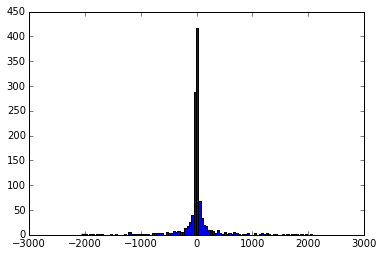

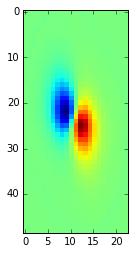

In [177]:
plt.figure()
diff = img_wld - f
print diff.max()
print diff.min()
_ = plt.hist(diff.flatten(),np.linspace(diff.min(),diff.max(),num=100))
plt.figure()
plt.imshow(diff)

model_p
(19, 22)
14524.8
16.3981

galaxy_profile_p
(19, 22)
0.110113
33222.1

galaxy_model_p
(19, 22)
-0.00130889
0.00147046

psf_model_p
(19, 22)
1.06246e-05
0.0488627

final_p
(301, 301)
-0.00119027
14529.5
1.04996e+06

datacube_image
0.0
14529.4853516
(49, 23)


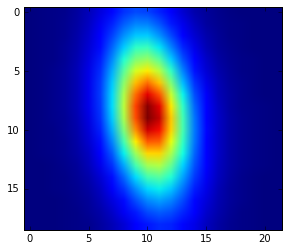

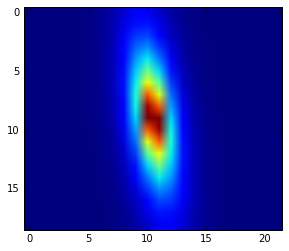

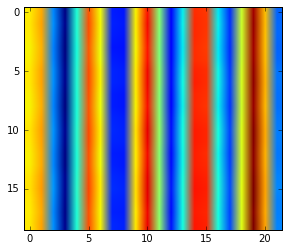

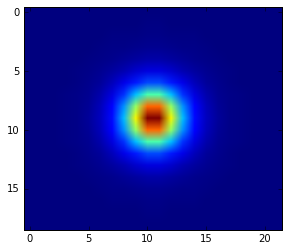

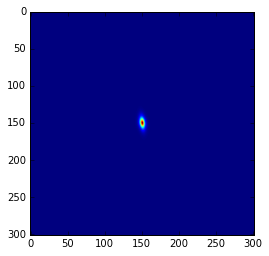

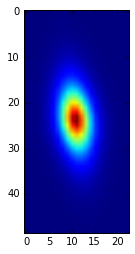

In [42]:
import pickle 
#use pickled wld image 
os.chdir(WLD)
model_p = (pickle.load(open("model.p","rb"))).array
galaxy_model_p = (pickle.load(open("galaxy_model.p","rb"))).array
galaxy_profile_p = (pickle.load(open("galaxy_profile.p","rb"))).array
psf_model_p = (pickle.load(open("psf_model.p","rb"))).array 
final_p = (pickle.load(open("final.p","rb"))).array 
print 'model_p'
print model_p.shape
print model_p.max() 
print model_p.min()
plt.figure()
plt.imshow(model_p)
print 
print 'galaxy_profile_p'
print galaxy_profile_p.shape
print galaxy_profile_p.min()
print galaxy_profile_p.max() 
plt.figure()
plt.imshow(galaxy_profile_p)
print
print 'galaxy_model_p'
print galaxy_model_p.shape
print galaxy_model_p.min()
print galaxy_model_p.max()
plt.figure()
plt.imshow(galaxy_model_p)
print
print 'psf_model_p'
print psf_model_p.shape
print psf_model_p.min()
print psf_model_p.max()
plt.figure()
plt.imshow(psf_model_p)
print
print 'final_p'
print final_p.shape
print final_p.min()
print final_p.max()
print final_p.sum()
plt.figure()
plt.imshow(final_p)
print 
print 'datacube_image'
img_wld = fits[2].read()[0]
print img_wld.min()
print img_wld.max()
print img_wld.shape
plt.figure()
plt.imshow(img_wld)